# Recommendation Engine for Movie Reviews
Factorization Machine (FM) is one of the newest algorithms in the Machine Learning space, and has been developed in SAS. FM is a general prediction algorithm, similar to Support Vector Machines, that can deal with very sparce data, an area where traditional Machine Learning techniques fail.
<br>

Recommendation Engines are notoriously difficult due to their sparcity. We have many users and many rated items, but most users have rated very few of the items. Therefore, we will try to use a Factorization Machine to implement new movie recommendations for users
<br>

This notebook has **four** parts:
1. Data Exploration
2. Recommendation Engine Considerations
3. Train Recommendation Engine
4. Make Recommendations

In [4]:
import swat
from swat import *
from swat.render import render_html
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from IPython.display import HTML
swat.options.cas.print_messages = False

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Connect to the session
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'

s = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

# Define directory and data file name
indata_dir="/opt/sasinside/DemoData"
indata='movie_reviews'
movie_info= 'movies_10k_desc'

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
s.table.addCaslib(datasource={'srctype':'path'}, name='DMlib', path=indata_dir);

# Push the relevant table In-Memory if it does not already exist
## Note, this is a server side data load, not being loaded from the client
s.loadTable(caslib='DMlib', path=indata+'.sas7bdat', casout={'name':indata});
s.loadTable(caslib='DMlib', path=movie_info+'.sas7bdat', casout={'name':movie_info});

# Load necessary actionsets
actions = ['fedSQL', 'transpose','sampling','factmac','astore']
[s.loadactionset(i) for i in actions]

# Set variables for later use by models
target          = 'rating'
class_inputs    = ['usr_id', 'movie']
all_inputs      = [target] + class_inputs

#Pointer Shortcut
def cas_p(table):
    pointer = s.CASTable(table)
    return pointer

# Part I: Data Exploration
### We have the following input datasets/explorations available:
* Movie Dataset: Additional metadata, such as year, genre, and parental rating for movies
* User Ratings: Movie Ratings available for each user
* Overall Average: Average Rating across all users and movie
<br>

Our goal is to recommend two new movies for each user

## Movie Dataset

In [4]:
print(len(cas_p(movie_info)), "Movies")
cas_p(movie_info).head()

1226 Movies


,movieId,title,year,genres,parental_rating
0,1.0,Toy Story,1995.0,Adventure|Animation|Children|Comedy|Fantasy,G
1,2.0,Jumanji,1995.0,Adventure|Children|Fantasy,PG
2,3.0,Grumpier Old Men,1995.0,Comedy|Romance,PG-13
3,4.0,Waiting to Exhale,1995.0,Comedy|Drama|Romance,R
4,5.0,Father of the Bride Part II,1995.0,Comedy,PG


## User Ratings

In [5]:
print(len(cas_p(indata)), "Ratings")
print(len(cas_p(indata)[class_inputs[0]].value_counts()), "Users")
s.CASTable(indata).head()

10000 Ratings
385 Users


,usr_id,movie,rating
0,196.0,242.0,3.0
1,186.0,302.0,3.0
2,22.0,377.0,1.0
3,244.0,51.0,2.0
4,166.0,346.0,1.0


## Distribution of Overall Reviews

3.5588 Average Review


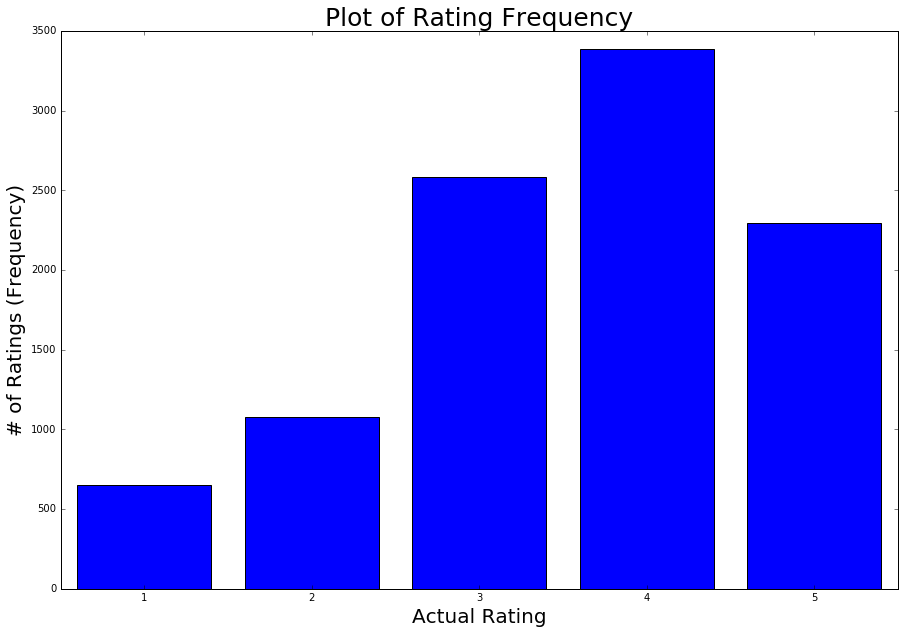

In [6]:
freq_table = (s.fedSQL.execDirect('''
    SELECT ''' + target + ''', count(*) as Frequency
    FROM '''+ indata +'''
    GROUP BY ''' + target + ''';
''')['Result Set'].sort_values(target)).set_index(np.arange(1,6))

plt.figure(figsize = (15, 10))
plt.bar(np.arange(1,6),freq_table['FREQUENCY'], align='center')
plt.xlabel('Actual Rating', size=20)
plt.ylabel('# of Ratings (Frequency)', size=20)
plt.title('Plot of Rating Frequency', size=25)
plt.xlim([.5,5.5]);
print(cas_p(indata)[target].mean(), "Average Review")

# Part II: Recommendation Engine Considerations
## Two Items to Consider:
* Holdout Sample: For Validation of Model
* Model Bias:
    * Global Bias: Average rating for all users and movies
    * User Bias: Average rating per user
    * Movie Bias: Average rating per movie
<br>




## Holdout Sample
Factorization machines need to be validated on users and movies that have been included in the training
<br>
To accomplish this, we will stratify on both user and movie
<br>
We will use a large training sample of ~90% of the data

In [7]:
# Create a 70/30 stratified Split on Users
s.sampling.stratified(
    table   = dict(name = indata, groupby = class_inputs[0]),
    output  = dict(casOut = dict(name = indata + '_prt_' + class_inputs[0], replace = True), copyVars = 'ALL'),
    samppct = 70,
    partind = True,
    seed    = 123
)

# Create a 70/30 split for the movies
s.sampling.stratified(
    table   = dict(name = indata, groupby = class_inputs[1]),
    output  = dict(casOut = dict(name = indata + '_prt_' + class_inputs[1], replace = True), copyVars = 'ALL'),
    samppct = 70,
    partind = True,
    seed    = 123
)

# Combine the samples together into one dataset so that it's stratified by user and movie
# Make the data 'blind' if it is part of the validation set so that it can be assessed
s.fedSQL.execDirect('''
    CREATE TABLE ''' + indata +'''_prt {options replace=true} AS
    SELECT
        a.''' + class_inputs[0] + ''',
        a.''' + class_inputs[1] + ''',
        a.''' + target + ''',
        CASE WHEN a._PartInd_ + b._PartInd_ > 0 THEN 1 ELSE 0 END AS _PartInd_
    FROM 
        ''' + indata + '_prt_' + class_inputs[0] + ''' a
        INNER JOIN ''' + indata + '_prt_' + class_inputs[1] + ''' b 
            ON  a.''' + class_inputs[0] + ' = b.' + class_inputs[0] + '''
            AND a.''' + class_inputs[1] + ' = b.' + class_inputs[1] + ''';
''')
cas_p(indata + '_prt')[all_inputs].query('_PartInd_=0').head()

,rating,usr_id,movie
0,2.0,244.0,51.0
1,4.0,63.0,277.0
2,3.0,50.0,246.0
3,4.0,251.0,100.0
4,3.0,243.0,15.0


## Bias Tables

Bias occurs because users unknowingly rate on different scales. Thus, a four star rating does not mean the same thing for two different users
<br>

The Factorization Machine accounts for this bias by assuming a predicted rating is the sum of:
1. A global bias (the average rating over all users and movies)
2. A per-user bias (the average of the ratings given by the user)
3. A per-item bias (the average of the ratings given to that movie)
4. And a pairwise interaction term between the user and that particular item

<br>
Factorization Machines account for these innate biases when making predictions, and are able to estimate the pairwise interactions between specific users and movies in sparse data.

### Overall Bias

In [8]:
cas_p(indata)[target].mean()

3.5588000000000002

### User Bias Table

In [9]:
# We can use SQL to find this, and further format using Python - sort_values() and head()
render_html(
s.fedSQL.execDirect('''
    SELECT 
        ''' + class_inputs[0] + ''', 
        COUNT(''' + target + ''') AS num_ratings, 
        AVG(''' + target + ''') AS avg_rating,
        AVG(''' + target + ''')-3.55 AS user_bias
    FROM ''' + indata + '''
    GROUP BY usr_id
''')['Result Set'].sort_values(class_inputs[0]).head()
)

1,85,3.6235294118,0.0735294118
2,12,3.5,-0.05
3,15,2.4,-1.15
4,6,4,0.45
5,48,2.9166666667,-0.633333333


### Movie Bias Table

In [10]:
# I could use SQL to find this as well, but decided to use Python built-in functionality - groupby()
movie_bias = s.CASTable(indata).groupby(class_inputs[1])[target].summary(subset=['N','Mean']).concat_bygroups().Summary
movie_bias['Movie_Bias'] = movie_bias['Mean'] - 3.55
movie_bias.head()

,Column,N,Mean,Movie_Bias
movie,,,,
1,rating,35.0,3.771429,0.221429
2,rating,13.0,3.153846,-0.396154
3,rating,7.0,3.428571,-0.121429
4,rating,21.0,3.619048,0.069048
5,rating,4.0,3.250000,-0.300000


# Part III: Train the Recommendation Engine
* Factorization Machine Training
* Assess Model on holdout Sample
* See Actual Rating vs Predicted

In [11]:
# Transpose the data using the completely redesigned transpose CAS action - this is running multi-threaded
test=s.transpose(
    table  = dict(name = indata, groupBy = class_inputs[0], vars = target),
    id     = class_inputs[1],
    casOut = dict(name = indata + '_transposed', replace = True)
)

## Factorization Machine Training
The algorithm runs 5 iterations until converging <br>

Note: We use Mean Squared Error(MSE) and Root Mean Squared Error(RMSE) to meausure the accuracy of our training. <br>

In [12]:
# Build the factorization machine
r = s.factmac.factmac(
  table     = dict(name = indata + '_prt', where = '_PartInd_ = 1'),
  inputs    = class_inputs,
  nominals  = class_inputs,
  target    = target,
  maxIter   = 5,
  nFactors  = 2,
  learnStep = 0.1,
  seed      = 12345,
  savestate = dict(name = 'fm_model', replace = True)
)

r['FinalLoss']

,Criterion,Value
0,MSE,0.662292
1,RMSE,0.813813


## Assess Model Holdout Sample
We want to calculate these fit statistics on the holdout sample to get an unbiased estimate of model performance on new data. We want to ensure that ourengines makes robust predicitons on new data and does not overfit
<br>

Note: A RMSE of 1 means that on average we miss the actual rating by 1 star

In [13]:
# Score the factorization machine
s.CASTable(indata + '_prt').astore.score(
  rstore   = dict(name = 'fm_model'),
  out      = dict(name = indata + '_scored', replace = True),
  copyVars = all_inputs + ['_PartInd_']
)

# Find the (predicted - actual) error rate on the validation set
s.fedSQL.execDirect('''
    CREATE TABLE eval {options replace=true} AS
    SELECT 
        a.*, 
        a.P_''' + target + ' - a.' + target + ''' AS error
    FROM
        ''' + indata + '''_scored a
    WHERE a._PartInd_= 0
''')

# Compute the Mean Squared Error and Root Mean Squared Error
s.fedSQL.execDirect('''
    SELECT 
        AVG(error**2) AS MSE,
        SQRT(AVG(error**2)) AS RMSE
    FROM eval
''')

,MSE,RMSE
0,1.360944,1.166595


## See Actual Rating vs Average Predicted Rating
What we are hoping to see is that the average prediction has a positive correlation with the actual rating.

In [14]:
rating = (s.fedSQL.execDirect('''
    SELECT ''' + target + ''', 
            count(*) AS freqnency,
            AVG(P_''' + target + ''') AS avg_prediction
    FROM eval
    GROUP BY ''' + target + ''';
''')['Result Set'].sort_values(target)).set_index(np.arange(1,6))

rating

,rating,FREQNENCY,AVG_PREDICTION
1,1.0,49.0,2.398545
2,2.0,94.0,3.128448
3,3.0,235.0,3.339986
4,4.0,315.0,3.687406
5,5.0,189.0,4.045055


## Let's plot this table using Matplotlib
* Bars Represent Actual Rating
* Line Represents the Average Predicted Rating for each rating level (1-5 stars)

* The Relationship is linear, although we have room for improvement on lower end (1 star) or upper end (5 star)

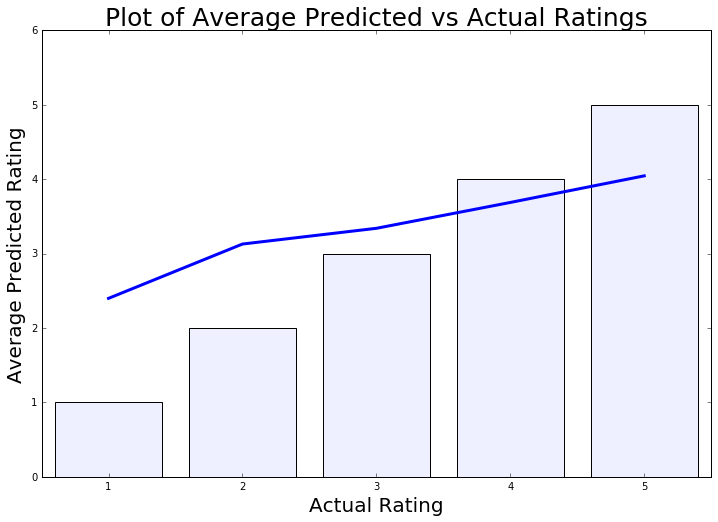

In [15]:
plt.figure(figsize = (12, 8))
plt.bar(np.arange(1,6),rating['rating'], color='#eeefff', align='center')
plt.plot(rating['rating'], rating['AVG_PREDICTION'], linewidth=3, label='Average Prediction')
plt.xlabel('Actual Rating', size=20)
plt.ylabel('Average Predicted Rating', size=20)
plt.title('Plot of Average Predicted vs Actual Ratings', size=25)
#plt.legend(loc='upper right', shadow=True)
plt.ylim([0,6])
plt.xlim([.5,5.5]);

# Part IV: Make Recommendations for Users
Here, we display the top two rated movies for ten users in our dataset
* The recommendations have the highest predicted ratings for that specific user
* Algorithm only recommends movies the user has not seen

In [16]:
# Find the movies the users have not watched and predict their potential rating
s.transpose(
    table = dict(name = indata + '_transposed', groupBy = class_inputs[0]),
    casOut = dict(name = indata + '_long', replace = True)
)
s.dataStep.runcode('''
data ''' + indata + '''_long;
    set ''' + indata + '''_long;
    ''' + class_inputs[1] + ''' = 1.0*_NAME_;
    drop _NAME_;
''')
astore = s.CASTable(indata + '_long')[all_inputs].query(target + ' is null').astore.score(
  rstore   = dict(name = 'fm_model'),
  out      = dict(name = indata + '_scored_new', replace = True),
  copyVars = class_inputs
)

In [17]:
s.fedSQL.execDirect('''
CREATE TABLE scored_metadata AS
    SELECT 
        a.*,
        b.title,
        b.year,
        b.genres,
        b.Parental_Rating
    FROM 
         movie_reviews_scored_new a
        INNER JOIN '''+ movie_info +''' b
    ON
        a.'''+ class_inputs[1] +''' = b.movieId
''')

s.CASTable('scored_metadata') \
    .groupby(class_inputs[0]) \
    .sort_values([class_inputs[0], 'P_' + target], ascending = [True, False]) \
    .query("parental_rating ^= 'NA'") \
    .head(2) \
    .head(14)

,P_rating,movie,title,year,genres,parental_rating
usr_id,,,,,,
1.0,6.397084,621.0,My Favorite Season,1993.0,Drama,N/A
1.0,5.956857,1203.0,12 Angry Men,1957.0,Drama,APPROVED
2.0,5.749650,990.0,Maximum Risk,1996.0,Action|Adventure|Thriller,R
2.0,5.585193,611.0,Hellraiser: Bloodline,1996.0,Action|Horror|Sci-Fi,R
3.0,4.136953,621.0,My Favorite Season,1993.0,Drama,N/A
3.0,4.123876,1463.0,That Old Feeling,1997.0,Comedy|Romance,PG-13
4.0,6.928676,1045.0,Love Is All There Is,1996.0,Comedy|Drama,R
4.0,6.747455,641.0,"Little Indian, Big City",1994.0,Adventure|Children|Comedy,PG
5.0,5.416161,1242.0,Glory,1989.0,Drama|War,R


In [18]:
s.close() #close the session